In [1]:
%matplotlib inline


Bad key "text.kerning_factor" on line 4 in
C:\Users\sensio\miniconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


# How nangs works

In this notebook we show how nangs works. We will solve the following PDE:

\begin{equation}
    \frac{\partial \phi}{\partial t} + u \frac{\partial \phi}{\partial x} = 0
\end{equation}

The independent variables (i.e, $x$ and $t$) are used as input values for the NN, and the solution (i.e. $\phi$) is the output. In order to find the solution, at each step the NN outputs are derived w.r.t the inputs. Then, a loss function that matches the PDE is built and the weights are updated accordingly. If the loss function goes to zero, we can assume that our NN is indeed the solution to our PDE. 

In [2]:
# imports

import numpy as np 
import matplotlib.pyplot as plt 
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

torch.__version__

'1.5.0'

## Define your data

To solve the PDE we first need a set of points to evaluate it, we will use this points as the dataset for training de NN.

In [3]:
# define the mesh
x = np.linspace(0,1,20)
t = np.linspace(0,1,30)

# combine all points
m = np.meshgrid(x, t)
m = np.stack(m, -1).reshape(-1, 2)
m.shape

(600, 2)

In [4]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, X):
        self.X = torch.from_numpy(X).to(device).float()
    def __len__(self):
        return len(self.X)
    def __getitem__(self, ix):
        return self.X[ix]
    
dataset = Dataset(m)

len(dataset)

600

## Define your solution topology

We use a Multilayer Perceptron to approximate the solution to the PDE

In [5]:
# solution topology

class Sine(torch.nn.Module):  
    def __init__(self):
        super().__init__()
    def forward(self, x):
        return torch.sin(x)
    
def block(i, o):
    fc = torch.nn.Linear(i, o)
    return torch.nn.Sequential(
        Sine(),
        torch.nn.Linear(i, o) 
    )

class MLP(torch.nn.Module):
    def __init__(self, inputs, outputs, layers, neurons):
        super().__init__()
        fc_in = torch.nn.Linear(inputs, neurons)
        fc_hidden = [
            block(neurons, neurons)
            for layer in range(layers-1)
        ]
        fc_out = block(neurons, outputs)
        
        self.mlp = torch.nn.Sequential(
            fc_in,
            *fc_hidden,
            fc_out
        )

    def forward(self, x):
        return self.mlp(x)
    
mlp = MLP(2, 1, 3, 100)
mlp

MLP(
  (mlp): Sequential(
    (0): Linear(in_features=2, out_features=100, bias=True)
    (1): Sequential(
      (0): Sine()
      (1): Linear(in_features=100, out_features=100, bias=True)
    )
    (2): Sequential(
      (0): Sine()
      (1): Linear(in_features=100, out_features=100, bias=True)
    )
    (3): Sequential(
      (0): Sine()
      (1): Linear(in_features=100, out_features=1, bias=True)
    )
  )
)

In [6]:
# check output shape

mlp(torch.randn(100,2)).shape

torch.Size([100, 1])

## Boundary conditions

We can attempt to solve our PDE at this points, but we would obtain a trivial solution. Instead, we need to specify a set of boundary conditions.

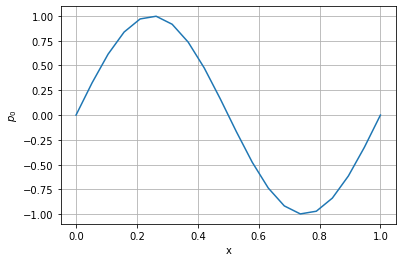

In [7]:
# initial condition (t = 0)

t0 = np.array([0.])
m0 = np.meshgrid(x, t0)
m0 = np.stack(m0, -1).reshape(-1, 2)

p0 = np.sin(2*np.pi*x)

plt.plot(x, p0)
plt.grid(True)
plt.xlabel('x')
plt.ylabel('$p_0$')
plt.show()

In [8]:
class DirichletDataset(torch.utils.data.Dataset):
    def __init__(self, X, Y):
        assert len(X) == len(Y)
        self.X = torch.from_numpy(X).to(device).float()
        self.Y = torch.from_numpy(Y).to(device).float()
    def __len__(self):
        return len(self.X)
    def __getitem__(self, ix):
        return self.X[ix], self.Y[ix]
    
# we use the names to indicate the order of the variables in the data
initial_condition_dataset = DirichletDataset(m0, p0.reshape(-1, 1))

len(initial_condition_dataset)

20

In [9]:
# boundary conditions (peridic conditions at x = 0 and x = 1)

xb0 = np.array([0])
mb0 = np.meshgrid(xb0, t)
mb0 = np.stack(mb0, -1).reshape(-1, 2)
mb0.shape

(30, 2)

In [10]:
xb1 = np.array([1])
mb1 = np.meshgrid(xb1, t)
mb1 = np.stack(mb1, -1).reshape(-1, 2)
mb1.shape

(30, 2)

In [11]:
boco_dataset = DirichletDataset(mb0, mb1)

len(boco_dataset)

30

## Solve the PDE

We can now proceed with solving the PDE

In [12]:
BATCH_SIZE = 32
EPOCHS = 50
U = 1

dataloaders = {
    'inner': torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True),
    'initial': torch.utils.data.DataLoader(initial_condition_dataset, batch_size=BATCH_SIZE, shuffle=True),
    'periodic': torch.utils.data.DataLoader(boco_dataset, batch_size=BATCH_SIZE, shuffle=True)
}

mlp = MLP(2, 1, 3, 128)
mlp.to(device)
optimizer = torch.optim.Adam(mlp.parameters())
criterion = torch.nn.MSELoss()

hist = []
for epoch in range(1, EPOCHS+1):
    # iterate over the internal points in batches
    for batch in dataloaders['inner']:
        X = batch
        optimizer.zero_grad()
        # optimize for boundary points
        losses = 0
        for batch in dataloaders['initial']:
            x, y = batch
            p = mlp(x)
            loss = criterion(p, y)
            loss.backward()
            losses += loss.item()
        for batch in dataloaders['periodic']:
            x1, x2 = batch
            p1 = mlp(x1)
            p2 = mlp(x2)
            loss = criterion(p1, p2)
            loss.backward()
            losses += loss.item()
        # optimize for internal points
        X.requires_grad = True
        p = mlp(X)
        grads, = torch.autograd.grad(p, X, 
                    grad_outputs=p.data.new(p.shape).fill_(1),
                    create_graph=True, only_inputs=True)
        dpdx, dpdt = grads[:,0], grads[:,1]
        pde = dpdt + U*dpdx
        loss = pde.pow(2).mean()
        loss.backward()
        optimizer.step()
        losses += loss.item()
        hist.append(losses)
    print(f"Epoch {epoch}/{EPOCHS} loss {losses:.5f}")

Epoch 1/50 loss 0.44584
Epoch 2/50 loss 0.43346
Epoch 3/50 loss 0.42094
Epoch 4/50 loss 0.40049
Epoch 5/50 loss 0.35735
Epoch 6/50 loss 0.17384
Epoch 7/50 loss 0.11475
Epoch 8/50 loss 0.09106
Epoch 9/50 loss 0.07281
Epoch 10/50 loss 0.06439
Epoch 11/50 loss 0.05049
Epoch 12/50 loss 0.02657
Epoch 13/50 loss 0.00799
Epoch 14/50 loss 0.00553
Epoch 15/50 loss 0.00346
Epoch 16/50 loss 0.00295
Epoch 17/50 loss 0.00208
Epoch 18/50 loss 0.00168
Epoch 19/50 loss 0.00208
Epoch 20/50 loss 0.00168
Epoch 21/50 loss 0.00113
Epoch 22/50 loss 0.00112
Epoch 23/50 loss 0.00136
Epoch 24/50 loss 0.00091
Epoch 25/50 loss 0.00076
Epoch 26/50 loss 0.00076
Epoch 27/50 loss 0.00062
Epoch 28/50 loss 0.00096
Epoch 29/50 loss 0.00104
Epoch 30/50 loss 0.00077
Epoch 31/50 loss 0.00039
Epoch 32/50 loss 0.00048
Epoch 33/50 loss 0.00067
Epoch 34/50 loss 0.00038
Epoch 35/50 loss 0.00036
Epoch 36/50 loss 0.00030
Epoch 37/50 loss 0.00043
Epoch 38/50 loss 0.00046
Epoch 39/50 loss 0.00067
Epoch 40/50 loss 0.00049
Epoch 41/

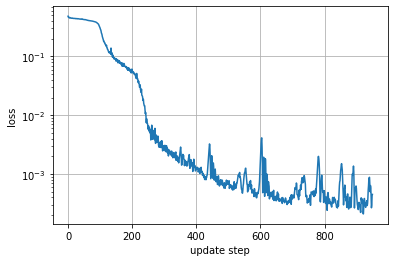

In [13]:
plt.plot(hist)
plt.xlabel("update step")
plt.ylabel("loss")
plt.yscale("log")
plt.grid(True)
plt.show()

## Evaluate your solution



In [14]:
def build_mesh(N, t):
    x = np.linspace(0,1,N)
    _t = np.array([t])
    m = np.meshgrid(x, _t)
    m = np.stack(m, -1).reshape(-1, 2)
    return x, t, m

x, t, m = build_mesh(20, 0)

In [15]:
def eval_model(m):
    mlp.eval()
    with torch.no_grad():
        p = mlp(torch.tensor(m).float().to(device)).cpu().numpy()
    return p

p = eval_model(m)

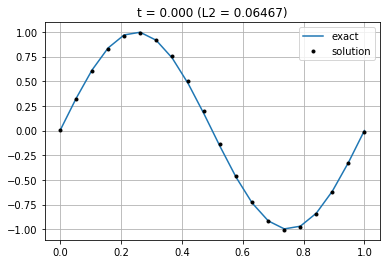

In [16]:
def plot_model(x, p, t):
    pe = np.sin(2.*np.pi*(x-U*t)).reshape(-1,1)
    plt.plot(x, pe, label="exact")
    plt.plot(x, p, '.k', label="solution")
    plt.legend()
    plt.grid(True)
    l2 = np.sqrt(np.sum((p-pe)**2))
    plt.title(f"t = {t:.3f} (L2 = {l2:.5f})")
    plt.show()
    
plot_model(x, p, 0)

In [17]:
def eval_solution(N, t):
    x, t, m = build_mesh(N, t)
    p = eval_model(m)
    plot_model(x, p, t)

In [18]:
from matplotlib import animation, rc
rc('animation', html='html5')

t = np.linspace(0,1,10)
x, t, m = build_mesh(30, t)
p = eval_model(m).reshape(len(t), -1)

fig = plt.figure()
ax = plt.subplot(111)
def update_plot(i):
    ax.clear()
    pe = np.sin(2.*np.pi*(x-U*t[i]))
    ax.plot(x, pe, label=f"exact (u = {U})")
    ax.plot(x, p[i], '.k', label="solution")
    ax.set_xlabel("x", fontsize=14)
    ax.set_ylabel("p", fontsize=14, rotation=np.pi/2)
    ax.legend(loc="upper right")
    ax.grid(True)
    ax.set_xlim([0, 1])
    ax.set_ylim([-1.2, 1.2])
    l2 = np.sqrt(np.sum((p[i]-pe)**2))
    ax.set_title(f"t = {t[i]:.3f} (L2 = {l2:.5f})")
    return ax

anim = animation.FuncAnimation(fig, update_plot, frames=len(t), interval=300)
plt.close()


In [19]:
anim

## What nangs provides you

Nangs will provideo you with classes and functions to asbtract some of the concepts explained here in order to enable fast experimentation while allowing you to customize it to your needs.